In [30]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_olivetti_faces

from secureml.utils import DataSet

import random

In [31]:
class Client(torch.nn.Module):
    def __init__(self, model, user_id=0):
        super().__init__()
        self.model = model
        self.user_id = user_id

    def forward(self, x):
        output = self.model(x)
        return output

    def upload(self):
        return self.model.cpu().state_dict()

    def download(self, model_parameters):
        self.model.load_state_dict(model_parameters)

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

In [32]:
def transform_list_to_tensor(model_params_list):
    for k in model_params_list.keys():
        model_params_list[k] = torch.from_numpy(
            np.asarray(model_params_list[k])
        ).float()
    return model_params_list


class Server:
    def __init__(self, clients, global_model, servre_id=0):
        self.clients = clients
        self.servre_id = servre_id
        self.num_clients = len(clients)
        self.global_model = global_model

    def update(self, weight=None):
        if weight is None:
            weight = np.ones(self.num_clients) / self.num_clients
            
        uploaded_parameters = [c.upload() for c in self.clients]
        averaged_params = uploaded_parameters[0]
        
        for k in averaged_params.keys():
            for i in range(0, len(uploaded_parameters)):
                local_model_params = uploaded_parameters[i]
                w = weight[i]
                if i == 0:
                    averaged_params[k] = local_model_params[k] * w
                else:
                    averaged_params[k] += local_model_params[k] * w
                    
        self.global_model.load_state_dict(averaged_params)

    def distribtue(self):
        for client in self.clients:
            client.download(self.global_model.cpu().state_dict())

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(64*64, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [41]:
class GAN_Attack_Client(Client):
    def __init__(
        self,
        model,
        target_label,
        generator,
        generator_optimizer,
        generator_criterion,
        nz=100,
        user_id=0,
        device="cpu",
    ):
        super().__init__(model, user_id=user_id)
        self.target_label = target_label
        self.generator = generator
        self.generator_optimizer = generator_optimizer
        self.generator_criterion = generator_criterion
        self.nz = nz
        self.device = device

        self.discriminator = copy.deepcopy(model)

    def update_generator(self, dataloader, epoch=1, log_interval=5):
        for i in range(epoch):
            running_error = 0
            data_size = 0
            for _, data in enumerate(dataloader, 0):
                self.generator.zero_grad()
                real_cpu = data[0].to(self.device)
                b_size = real_cpu.size(0)
                data_size += b_size
                label = torch.full(
                    (b_size,), self.target_label, dtype=torch.int64, device=self.device
                )
                noise = torch.randn(b_size, self.nz, 1, 1, device=self.device)
                fake = self.generator(noise)
                output = self.discriminator(fake)
                loss_generator = self.generator_criterion(output, label)
                loss_generator.backward()
                self.generator_optimizer.step()

                running_error += loss_generator.item()
    
            if i % log_interval == 0:
                print(f"{i} - {running_error/data_size}")
                
    def attack(self, n):
        noise = torch.randn(n, self.nz, 1, 1, device=self.device)
        with torch.no_grad():
            fake = self.generator(noise).view
        return fake

In [35]:
inputs.shape

torch.Size([4, 1, 64, 64])

In [36]:
# Generator Code (from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

class Generator(nn.Module):
    def __init__(self, nz, nc, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [37]:
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64

In [38]:
at_t_dataset = fetch_olivetti_faces()        
X = at_t_dataset["images"]
y = at_t_dataset["target"]

# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

idx_1 = random.sample(range(400), 200)
idx_2 = list(set(range(400)) - set(idx_1))

global_trainset = DataSet(X, y, transform=transform)
global_trainloader = torch.utils.data.DataLoader(global_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
trainset_1 = DataSet(X[idx_1], y[idx_1], transform=transform)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=4,
                                          shuffle=True, num_workers=2)
trainset_2 = DataSet(X[idx_2], y[idx_2], transform=transform)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=4,
                                          shuffle=True, num_workers=2)

trainloaders = [trainloader_1, trainloader_2]
dataset_nums = [200, 200]

In [8]:
net_1 = Net()
client_1 = Client(net_1, user_id=0)
optimizer_1 = optim.SGD(client_1.parameters(), lr=0.005, momentum=0.9)

net_2 = Net()
client_2 = Client(net_2, user_id=0)
optimizer_2 = optim.SGD(client_2.parameters(), lr=0.005, momentum=0.9)

clients = [client_1, client_2]
optimizers = [optimizer_1, optimizer_2]

server = Server(clients, Net())

In [9]:
criterion = nn.CrossEntropyLoss()
client_num = 2

for epoch in range(10): 
    for client_idx in range(client_num):
        client = clients[client_idx]
        trainloader = trainloaders[client_idx]
        optimizer = optimizers[client_idx]

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = client(inputs)
            loss = criterion(outputs, labels.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"epoch-{epoch}: client-{client_idx+1}",
              running_loss / dataset_nums[client_idx])
    
    server.update()
    server.distribtue()

epoch-0: client-1 0.9218211030960083
epoch-0: client-2 0.9218912661075592
epoch-1: client-1 0.9191890966892242
epoch-1: client-2 0.918871500492096
epoch-2: client-1 0.9106276357173919
epoch-2: client-2 0.9120814323425293
epoch-3: client-1 0.8939419567584992
epoch-3: client-2 0.8967595267295837
epoch-4: client-1 0.8772130262851715
epoch-4: client-2 0.8802297163009644


In [10]:
in_preds = []
in_label = []
with torch.no_grad():
        for data in global_trainloader:
            inputs, labels = data
            outputs = server.global_model(inputs)
            in_preds.append(outputs)
            in_label.append(labels)  
        in_preds = torch.cat(in_preds)
        in_label = torch.cat(in_label)

print(accuracy_score(np.array(torch.argmax(in_preds, axis=1)),
                     np.array(in_label)))

0.3325


In [44]:
net_1 = Net()
client_1 = Client(net_1, user_id=0)
optimizer_1 = optim.SGD(client_1.parameters(), lr=0.005, momentum=0.9)

net_2 = Net()
generator = Generator(nz, nc, ngf)
optimizer_g = optim.SGD(generator.parameters(), lr=0.02, momentum=0.9)
target_label = 0
client_2 = GAN_Attack_Client(net_2, target_label, generator,
                             optimizer_g, criterion, user_id=0)
optimizer_2 = optim.SGD(client_2.parameters(), lr=0.005, momentum=0.9)

clients = [client_1, client_2]
optimizers = [optimizer_1, optimizer_2]

server = Server(clients, Net())

In [45]:
criterion = nn.CrossEntropyLoss()
client_num = 2
adversary_client_id = 1

for epoch in range(10): 
    for client_idx in range(client_num):
        client = clients[client_idx]
        trainloader = trainloaders[client_idx]
        optimizer = optimizers[client_idx]

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = client(inputs)
            loss = criterion(outputs, labels.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"epoch-{epoch}: client-{client_idx+1}",
              running_loss / dataset_nums[client_idx])
        
        if client_idx == adversary_client_id:
            client.update_generator(trainloader)
    
    server.update()
    server.distribtue()

epoch-0: client-1 0.9216112422943116
epoch-0: client-2 0.9217164516448975
0 - 3.69150710105896
5 - 2.87933349609375
10 - 2.745025396347046
15 - 2.7356276512145996
20 - 2.735330820083618
25 - 2.734203815460205
30 - 2.7334907054901123
35 - 2.7332115173339844
40 - 2.732907772064209
45 - 2.7326292991638184
epoch-1: client-1 0.9180269753932953
epoch-1: client-2 0.9169635343551635
0 - 2.7327988147735596
5 - 2.7324399948120117
10 - 2.7323176860809326
15 - 2.7321436405181885
20 - 2.732272148132324
25 - 2.7319252490997314
30 - 2.7320103645324707
35 - 2.7319753170013428
40 - 2.7317254543304443
45 - 2.731830358505249
epoch-2: client-1 0.9055757439136505
epoch-2: client-2 0.9096765840053558
0 - 2.7316672801971436
5 - 2.731858015060425
10 - 2.7319586277008057
15 - 2.7317817211151123
20 - 2.7317209243774414
25 - 2.731722354888916
30 - 2.731776237487793
35 - 2.7317442893981934
40 - 2.731635332107544
45 - 2.7314648628234863
epoch-3: client-1 0.8927387428283692
epoch-3: client-2 0.8979940354824066
0 - 

In [61]:
client_2.attack(1).reshape(64, 64).shape

torch.Size([64, 64])

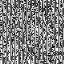

In [65]:
from PIL import Image
Image.fromarray(client_2.attack(1).reshape(64, 64).numpy(), mode="L")